In [1]:
from pyspark.sql import SparkSession, DataFrame
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

In [2]:
# Initialize Spark session
spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

24/10/05 22:04:03 WARN Utils: Your hostname, apples-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.13.7.83 instead (on interface en0)
24/10/05 22:04:03 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/05 22:04:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Read the Parquet file into a Spark DataFrame
sdf = spark.read.parquet("../data/curated/prop_cleaned2.parquet")
sdf.printSchema()   

root
 |-- postal_code: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- property_url: string (nullable = true)
 |-- beds: integer (nullable = true)
 |-- baths: integer (nullable = true)
 |-- parkings: integer (nullable = true)
 |-- cost: integer (nullable = true)
 |-- built_in_wardrobes: integer (nullable = true)
 |-- dishwasher: integer (nullable = true)
 |-- air_conditioning: integer (nullable = true)
 |-- floorboards: integer (nullable = true)
 |-- secure_parking: integer (nullable = true)
 |-- intercom: integer (nullable = true)
 |-- heating: integer (nullable = true)
 |-- ensuite: integer (nullable = true)
 |-- balcony_deck: integer (nullable = true)
 |-- gym: integer (nullable = true)
 |-- furnished: integer (nullable = true)
 |-- close_to_shops: integer (nullable = true)
 |-- close_to_transport: integer (nullable = true)
 |-- fully_fenced: integer (nullable = true)
 |-- close_to_schools: integer (nullable = true)
 |-- ducted_heating: integer (nullable = true)
 

In [4]:
def shape(sdf: DataFrame) -> None:
    """
    Returns the shape of a Spark DataFrame as a tuple (number of rows, number of columns).
    """
    num_rows = sdf.count()
    num_columns = len(sdf.columns)
    print(f"Shape of the DataFrame: {num_rows} rows, {num_columns} columns.")

shape(sdf)

Shape of the DataFrame: 9621 rows, 159 columns.


In [5]:
sdf.columns

['postal_code',
 'name',
 'property_url',
 'beds',
 'baths',
 'parkings',
 'cost',
 'built_in_wardrobes',
 'dishwasher',
 'air_conditioning',
 'floorboards',
 'secure_parking',
 'intercom',
 'heating',
 'ensuite',
 'balcony_deck',
 'gym',
 'furnished',
 'close_to_shops',
 'close_to_transport',
 'fully_fenced',
 'close_to_schools',
 'ducted_heating',
 'split_system_heating',
 'swimming_pool',
 'remote_garage',
 'balcony',
 'study',
 'garden_courtyard',
 'pets_allowed',
 'internal_laundry',
 'alarm_system',
 'prop_type_index',
 'parks_count',
 'parks_average_travel_time_mins',
 'parks_average_travel_distance_kms',
 'parks_time_distance_product',
 'schools_count',
 'schools_average_travel_time_mins',
 'schools_average_travel_distance_kms',
 'schools_time_distance_product',
 'supermarkets_count',
 'supermarkets_average_travel_time_mins',
 'supermarkets_average_travel_distance_kms',
 'supermarkets_time_distance_product',
 'hospitals_count',
 'hospitals_average_travel_time_mins',
 'hospitals

In [6]:
feature_columns = [
 'postal_code',
 'beds',
 'baths',
 'parkings',
 'built_in_wardrobes',
 'dishwasher',
 'air_conditioning',
 'floorboards',
 'secure_parking',
 'intercom',
 'heating',
 'ensuite',
 'balcony_deck',
 'gym',
 'furnished',
 'close_to_shops',
 'close_to_transport',
 'fully_fenced',
 'close_to_schools',
 'ducted_heating',
 'split_system_heating',
 'swimming_pool',
 'remote_garage',
 'balcony',
 'study',
 'garden_courtyard',
 'pets_allowed',
 'internal_laundry',
 'alarm_system',
 'prop_type_index',
 'parks_count',
 'parks_average_travel_time_mins',
 'parks_average_travel_distance_kms',
 'parks_time_distance_product',
 'schools_count',
 'schools_average_travel_time_mins',
 'schools_average_travel_distance_kms',
 'schools_time_distance_product',
 'supermarkets_count',
 'supermarkets_average_travel_time_mins',
 'supermarkets_average_travel_distance_kms',
 'supermarkets_time_distance_product',
 'hospitals_count',
 'hospitals_average_travel_time_mins',
 'hospitals_average_travel_distance_kms',
 'hospitals_time_distance_product',
 'shopping_districts_count',
 'shopping_districts_average_travel_time_mins',
 'shopping_districts_average_travel_distance_kms',
 'shopping_districts_time_distance_product',
 'cbd_count',
 'cbd_average_travel_time_mins',
 'cbd_average_travel_distance_kms',
 'cbd_time_distance_product',
 'train_stations_count',
 'train_stations_average_travel_time_mins',
 'train_stations_average_travel_distance_kms',
 'train_stations_time_distance_product',
 'mar_2000',
 'jun_2000',
 'sep_2000',
 'dec_2000',
 'mar_2001',
 'jun_2001',
 'sep_2001',
 'dec_2001',
 'mar_2002',
 'jun_2002',
 'sep_2002',
 'dec_2002',
 'mar_2003',
 'jun_2003',
 'sep_2003',
 'dec_2003',
 'mar_2004',
 'jun_2004',
 'sep_2004',
 'dec_2004',
 'mar_2005',
 'jun_2005',
 'sep_2005',
 'dec_2005',
 'mar_2006',
 'jun_2006',
 'sep_2006',
 'dec_2006',
 'mar_2007',
 'jun_2007',
 'sep_2007',
 'dec_2007',
 'mar_2008',
 'jun_2008',
 'sep_2008',
 'dec_2008',
 'mar_2009',
 'jun_2009',
 'sep_2009',
 'dec_2009',
 'mar_2010',
 'jun_2010',
 'sep_2010',
 'dec_2010',
 'mar_2011',
 'jun_2011',
 'sep_2011',
 'dec_2011',
 'mar_2012',
 'jun_2012',
 'sep_2012',
 'dec_2012',
 'mar_2013',
 'jun_2013',
 'sep_2013',
 'dec_2013',
 'mar_2014',
 'jun_2014',
 'sep_2014',
 'dec_2014',
 'mar_2015',
 'jun_2015',
 'sep_2015',
 'dec_2015',
 'mar_2016',
 'jun_2016',
 'sep_2016',
 'dec_2016',
 'mar_2017',
 'jun_2017',
 'sep_2017',
 'dec_2017',
 'mar_2018',
 'jun_2018',
 'sep_2018',
 'dec_2018',
 'mar_2019',
 'jun_2019',
 'sep_2019',
 'dec_2019',
 'mar_2020',
 'jun_2020',
 'sep_2020',
 'dec_2020',
 'mar_2021',
 'jun_2021',
 'sep_2021',
 'dec_2021',
 'mar_2022',
 'jun_2022',
 'sep_2022',
 'dec_2022',
 'mar_2023',
 'annual_increase',
 'median_inc',
 '2022_pop',
 '2023_pop',
 'pop_percentage_increase']

In [7]:
# Create a VectorAssembler to combine feature columns into a single vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# Transform the features into a single vector column
data = sdf.select('cost', *feature_columns)

data = assembler.transform(data)

data

24/10/05 22:04:42 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


cost,postal_code,beds,baths,parkings,built_in_wardrobes,dishwasher,air_conditioning,floorboards,secure_parking,intercom,heating,ensuite,balcony_deck,gym,furnished,close_to_shops,close_to_transport,fully_fenced,close_to_schools,ducted_heating,split_system_heating,swimming_pool,remote_garage,balcony,study,garden_courtyard,pets_allowed,internal_laundry,alarm_system,prop_type_index,parks_count,parks_average_travel_time_mins,parks_average_travel_distance_kms,parks_time_distance_product,schools_count,schools_average_travel_time_mins,schools_average_travel_distance_kms,schools_time_distance_product,supermarkets_count,supermarkets_average_travel_time_mins,supermarkets_average_travel_distance_kms,supermarkets_time_distance_product,hospitals_count,hospitals_average_travel_time_mins,hospitals_average_travel_distance_kms,hospitals_time_distance_product,shopping_districts_count,shopping_districts_average_travel_time_mins,shopping_districts_average_travel_distance_kms,shopping_districts_time_distance_product,cbd_count,cbd_average_travel_time_mins,cbd_average_travel_distance_kms,cbd_time_distance_product,train_stations_count,train_stations_average_travel_time_mins,train_stations_average_travel_distance_kms,train_stations_time_distance_product,mar_2000,jun_2000,sep_2000,dec_2000,mar_2001,jun_2001,sep_2001,dec_2001,mar_2002,jun_2002,sep_2002,dec_2002,mar_2003,jun_2003,sep_2003,dec_2003,mar_2004,jun_2004,sep_2004,dec_2004,mar_2005,jun_2005,sep_2005,dec_2005,mar_2006,jun_2006,sep_2006,dec_2006,mar_2007,jun_2007,sep_2007,dec_2007,mar_2008,jun_2008,sep_2008,dec_2008,mar_2009,jun_2009,sep_2009,dec_2009,mar_2010,jun_2010,sep_2010,dec_2010,mar_2011,jun_2011,sep_2011,dec_2011,mar_2012,jun_2012,sep_2012,dec_2012,mar_2013,jun_2013,sep_2013,dec_2013,mar_2014,jun_2014,sep_2014,dec_2014,mar_2015,jun_2015,sep_2015,dec_2015,mar_2016,jun_2016,sep_2016,dec_2016,mar_2017,jun_2017,sep_2017,dec_2017,mar_2018,jun_2018,sep_2018,dec_2018,mar_2019,jun_2019,sep_2019,dec_2019,mar_2020,jun_2020,sep_2020,dec_2020,mar_2021,jun_2021,sep_2021,dec_2021,mar_2022,jun_2022,sep_2022,dec_2022,mar_2023,annual_increase,median_inc,2022_pop,2023_pop,pop_percentage_increase,features
760,3000,2,2,1,1,0,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0,22.0,3.796666666666667,1.5133333333333334,5.745622222222223,2.0,3.31,1.4,4.6339999999999995,17.0,2.75,1.0799999999999998,2.9699999999999998,0.0,8.31,3.0,22.5201,8.0,3.426666666666667,1.3166666666666667,4.5117777777777786,1.0,3.32,1.4,4.648,3.0,4.375,1.65,7.21875,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,310.0,310.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,303.0,303.0,310.0,310.0,315.0,320.0,320.0,340.0,350.0,350.0,360.0,370.0,380.0,390.0,399.0,400.0,400.0,401.0,400.0,410.0,410.0,420.0,420.0,420.0,430.0,430.0,430.0,440.0,440.0,440.0,445.0,450.0,449.0,440.0,435.0,430.0,435.0,435.0,440.0,440.0,440.0,440.0,445.0,450.0,450.0,450.0,460.0,470.0,480.0,480.0,490.0,495.0,495.0,490.0,495.0,500.0,500.0,510.0,510.0,510.0,495.0,460.0,420.0,380.0,369.0,350.0,350.0,365.0,390.0,419.0,450.0,500.0,1.7891498549299083,38222.27067556402,15724.680567083857,18121.738315239138,15.243920141519387,"[3000.0,2.0,2.0,1..."
750,3000,2,2,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,8.65,2.99,20.8088,5.0,2.69,1.0725,2.885025,23.0,2.174782608695652,0.8843478260869565,1.9232642722117201,0.0,8.31,3.0,22.5201,11.0,2.4116666666666666,0.9533333333333335,2.2991222222222225,1.0,1.94,0.69,1.3385999999999998,0.0,7.64,3.0,21.154600000000002,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,310.0,310.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,303.0,303.0,310.0,310.0,315.0,320.0,320.0,340.0,350.0,350.0,360.0,370.0,380.0,390.0,399.0,400.0,400.0,401.0,400.0,410.0,410.0,420.0,420.0,420.0,430.0,430.0,430.0,440.0,440.0,440.0,445.0,450.0,449.0,440.0,435.0,430.0,435.0,435.0,440.0,440.0,440.0,440.0,445.0,450.0,450.0,450.0,460.0,470.0,480.0,480.0,490.0,495.0,495.0,490.0,495.0,500.0,500.0,510.0,510.0,510.0,495.0,460.0,420.0,3

In [8]:
# Create a StandardScaler instance
scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withMean=True, withStd=True)

# Fit the scaler to the data
scaler_model = scaler.fit(data)

# Transform the data using the fitted scaler
data = scaler_model.transform(data)

In [9]:
# Split the data into training and test sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed = 1003)
train_data

cost,postal_code,beds,baths,parkings,built_in_wardrobes,dishwasher,air_conditioning,floorboards,secure_parking,intercom,heating,ensuite,balcony_deck,gym,furnished,close_to_shops,close_to_transport,fully_fenced,close_to_schools,ducted_heating,split_system_heating,swimming_pool,remote_garage,balcony,study,garden_courtyard,pets_allowed,internal_laundry,alarm_system,prop_type_index,parks_count,parks_average_travel_time_mins,parks_average_travel_distance_kms,parks_time_distance_product,schools_count,schools_average_travel_time_mins,schools_average_travel_distance_kms,schools_time_distance_product,supermarkets_count,supermarkets_average_travel_time_mins,supermarkets_average_travel_distance_kms,supermarkets_time_distance_product,hospitals_count,hospitals_average_travel_time_mins,hospitals_average_travel_distance_kms,hospitals_time_distance_product,shopping_districts_count,shopping_districts_average_travel_time_mins,shopping_districts_average_travel_distance_kms,shopping_districts_time_distance_product,cbd_count,cbd_average_travel_time_mins,cbd_average_travel_distance_kms,cbd_time_distance_product,train_stations_count,train_stations_average_travel_time_mins,train_stations_average_travel_distance_kms,train_stations_time_distance_product,mar_2000,jun_2000,sep_2000,dec_2000,mar_2001,jun_2001,sep_2001,dec_2001,mar_2002,jun_2002,sep_2002,dec_2002,mar_2003,jun_2003,sep_2003,dec_2003,mar_2004,jun_2004,sep_2004,dec_2004,mar_2005,jun_2005,sep_2005,dec_2005,mar_2006,jun_2006,sep_2006,dec_2006,mar_2007,jun_2007,sep_2007,dec_2007,mar_2008,jun_2008,sep_2008,dec_2008,mar_2009,jun_2009,sep_2009,dec_2009,mar_2010,jun_2010,sep_2010,dec_2010,mar_2011,jun_2011,sep_2011,dec_2011,mar_2012,jun_2012,sep_2012,dec_2012,mar_2013,jun_2013,sep_2013,dec_2013,mar_2014,jun_2014,sep_2014,dec_2014,mar_2015,jun_2015,sep_2015,dec_2015,mar_2016,jun_2016,sep_2016,dec_2016,mar_2017,jun_2017,sep_2017,dec_2017,mar_2018,jun_2018,sep_2018,dec_2018,mar_2019,jun_2019,sep_2019,dec_2019,mar_2020,jun_2020,sep_2020,dec_2020,mar_2021,jun_2021,sep_2021,dec_2021,mar_2022,jun_2022,sep_2022,dec_2022,mar_2023,annual_increase,median_inc,2022_pop,2023_pop,pop_percentage_increase,features,scaled_features
150,3000,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,8.65,2.99,20.8088,3.0,4.003333333333333,1.43,5.724766666666666,18.0,2.1383333333333336,0.8350000000000002,1.785508333333334,5.0,3.4724999999999997,1.3375,4.64446875,10.0,2.566,1.092,2.802072,1.0,2.24,0.98,2.1952000000000003,4.0,3.14,1.33,4.176200000000001,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,310.0,310.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,303.0,303.0,310.0,310.0,315.0,320.0,320.0,340.0,350.0,350.0,360.0,370.0,380.0,390.0,399.0,400.0,400.0,401.0,400.0,410.0,410.0,420.0,420.0,420.0,430.0,430.0,430.0,440.0,440.0,440.0,445.0,450.0,449.0,440.0,435.0,430.0,435.0,435.0,440.0,440.0,440.0,440.0,445.0,450.0,450.0,450.0,460.0,470.0,480.0,480.0,490.0,495.0,495.0,490.0,495.0,500.0,500.0,510.0,510.0,510.0,495.0,460.0,420.0,380.0,369.0,350.0,350.0,365.0,390.0,419.0,450.0,500.0,1.7891498549299083,38222.27067556402,15724.680567083857,18121.738315239138,15.243920141519387,"[3000.0,1.0,1.0,1...",[-0.7022829520033...
155,3199,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.0,0.0,8.65,2.99,20.8088,2.0,1.27,0.66,0.8382000000000001,2.0,0.04,0.02,8.0E-4,0.0,8.31,3.0,22.5201,0.0,6.49,2.98,18.618,1.0,49.99,55.47,2772.9453,1.0,2.28,1.03,2.3484,150.0,150.0,150.0,155.0,155.0,155.0,160.0,160.0,160.0,165.0,165.0,170.0,170.0,170.0,175.0,180.0,180.0,180.0,180.0,180.0,185.0,185.0,190.0,190.0,190.0,195.0,195.0,200.0,200.0,210.0,215.0,220.0,230.0,235.0,240.0,250.0,250.0,260.0,260.0,260.0,265.0,270.0,280.0,281.0,290.0,290.0,295.0,295.0,295.0,295.0,295.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,305.0,310.0,310.0,310.0,320.0,320.0,325.0,330.0,330.0,330.0,335.0,340.0,348.0,350.0,350.0,355.0,360.0,360.0,360.0,360.0,360.0,365.0,370.0,370.0,370.0,375.0,375.0,380.0,390.0,400.0,410.0,420.0,430.0,440.0,450.0,4.91

In [10]:
# Initialize the Linear Regression model
lr = LinearRegression(featuresCol='scaled_features', labelCol='cost')

# Fit the model to the training data
lr_model = lr.fit(train_data)

24/10/05 22:05:07 WARN Instrumentation: [b3fc6468] regParam is zero, which might cause numerical instability and overfitting.
24/10/05 22:05:08 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/10/05 22:05:10 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
24/10/05 22:05:10 WARN Instrumentation: [b3fc6468] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


In [11]:
# Print model summary
print("Intercept: " + str(lr_model.intercept))
print("RMSE: " + str(lr_model.summary.rootMeanSquaredError))
print("r2: " + str(lr_model.summary.r2))

# Get the coefficients and feature names
coefficients = lr_model.coefficients.toArray()
feature_names = feature_columns

# Create a DataFrame from the coefficients and feature names
coefficients_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
})

# Sort the DataFrame by the 'coefficient' column in decreasing order
coefficients_df = coefficients_df.sort_values(by='coefficient', ascending=False)

# Evaluate the model on the test data
test_results = lr_model.evaluate(test_data)

# Print evaluation metrics
print("\nTest RMSE: ", test_results.rootMeanSquaredError)
print("Test r2: ", test_results.r2)

coefficients_df

Intercept: 564.2547992799986
RMSE: 76.25543781038827
r2: 0.5722521576180455



Test RMSE:  77.96805761430045
Test r2:  0.5616118688202443


,feature,coefficient
89,dec_2007,96.835814
1,beds,83.958303
81,dec_2005,79.633548
53,cbd_time_distance_product,79.208118
95,jun_2009,68.902871
...,...,...
88,sep_2007,-57.421467
98,mar_2010,-64.945325
116,sep_2014,-67.894360
51,cbd_average_travel_time_mins,-69.367275


In [12]:
# Initialize the Lasso Regression model
lasso = LinearRegression(featuresCol='features', labelCol='cost', elasticNetParam=0.5, regParam=0.1)

# Fit the model to the data
lasso_model = lasso.fit(train_data)

In [13]:
# Print model summary
print("Intercept: " + str(lasso_model.intercept))
print("RMSE: " + str(lasso_model.summary.rootMeanSquaredError))
print("r2: " + str(lasso_model.summary.r2))

# Get the coefficients and feature names
lasso_coefficients = lasso_model.coefficients.toArray()

# Create a DataFrame from the coefficients and feature names
lasso_coefficients_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': lasso_coefficients
})

# Sort the DataFrame by the 'coefficient' column in decreasing order
lasso_coefficients_df = lasso_coefficients_df.sort_values(by='coefficient', ascending=False)

# Evaluate the model on the test data
lasso_test_results = lasso_model.evaluate(test_data)

# Print evaluation metrics
print("\nLasso Test RMSE: ", lasso_test_results.rootMeanSquaredError)
print("Lasso Test r2: ", lasso_test_results.r2)

lasso_coefficients_df

Intercept: 114.3929056762743
RMSE: 78.70368640199983
r2: 0.5443447910853954



Lasso Test RMSE:  80.02103913548036
Lasso Test r2:  0.5382214760666317


,feature,coefficient
1,beds,76.816327
2,baths,58.173400
5,dishwasher,27.171938
16,close_to_transport,24.577907
13,gym,19.142649
...,...,...
18,close_to_schools,-8.539670
40,supermarkets_average_travel_distance_kms,-11.111908
22,remote_garage,-12.005031
4,built_in_wardrobes,-13.454950


In [14]:
def backward_elimination(data: DataFrame, features: list, label: str, stop_threshold=0.1):
    features_to_keep = features.copy()
    
    while len(features_to_keep) > 0:
        print(f"Training model with {len(features_to_keep)} features.")
        
        # Assemble the feature vector for the current set of features
        assembler = VectorAssembler(inputCols=features_to_keep, outputCol="features")
        
        # Drop the existing 'features' column if it exists
        if 'features' in data.columns:
            data = data.drop('features')

        # Transform the data to create the new 'features' column
        data_assembled = assembler.transform(data).select("features", label)
        
        # Create a StandardScaler instance
        scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withMean=True, withStd=True)
        
        # Fit the scaler to the data and transform it
        scaler_model = scaler.fit(data_assembled)
        data_scaled = scaler_model.transform(data_assembled)
        
        # Train the model on the scaled features
        lr = LinearRegression(featuresCol="scaled_features", labelCol=label)
        lr_model = lr.fit(data_scaled)
        
        # Get the coefficients and associated features
        coefficients = lr_model.coefficients
        coef_feature_pairs = list(zip(coefficients, features_to_keep))
        
        # Find the least significant feature (smallest coefficient magnitude)
        least_significant_feature = min(coef_feature_pairs, key=lambda x: abs(x[0]))[1]
        
        # Check the magnitude of the smallest coefficient using absolute value
        if abs(min(coef_feature_pairs, key=lambda x: abs(x[0]))[0]) < stop_threshold:
            print(f"Removing least significant feature: {least_significant_feature}")
            features_to_keep.remove(least_significant_feature)
        else:
            break

    print(f"Final set of features: {features_to_keep}")
    return features_to_keep

In [15]:
# Perform backward elimination
final_features = backward_elimination(data, feature_columns, 'cost', stop_threshold=15)

Training model with 156 features.


24/10/05 22:05:36 WARN Instrumentation: [5a337d0e] regParam is zero, which might cause numerical instability and overfitting.
24/10/05 22:05:37 WARN Instrumentation: [5a337d0e] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: cbd_count
Training model with 155 features.


24/10/05 22:05:41 WARN Instrumentation: [ae0782e5] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: 2022_pop
Training model with 154 features.


24/10/05 22:05:48 WARN Instrumentation: [9746f867] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: alarm_system
Training model with 153 features.


24/10/05 22:06:01 WARN Instrumentation: [dcb0fc2a] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: ducted_heating
Training model with 152 features.


24/10/05 22:06:17 WARN Instrumentation: [7ec4775a] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: mar_2005
Training model with 151 features.


24/10/05 22:06:30 WARN Instrumentation: [0510813a] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: train_stations_average_travel_distance_kms
Training model with 150 features.


24/10/05 22:06:40 WARN Instrumentation: [8ec471b1] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: split_system_heating
Training model with 149 features.


24/10/05 22:06:49 WARN Instrumentation: [006e4539] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: internal_laundry
Training model with 148 features.


24/10/05 22:06:55 WARN Instrumentation: [28ad0ed3] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: shopping_districts_time_distance_product
Training model with 147 features.


24/10/05 22:07:06 WARN Instrumentation: [9be7ff56] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: shopping_districts_count
Training model with 146 features.


24/10/05 22:07:15 WARN Instrumentation: [de3eb191] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: intercom
Training model with 145 features.


24/10/05 22:07:25 WARN Instrumentation: [eefaefc3] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: median_inc
Training model with 144 features.


24/10/05 22:07:35 WARN Instrumentation: [178b509b] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: ensuite
Training model with 143 features.


24/10/05 22:07:44 WARN Instrumentation: [744bff32] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: heating
Training model with 142 features.


24/10/05 22:07:52 WARN Instrumentation: [8e58fbc4] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: prop_type_index
Training model with 141 features.


24/10/05 22:07:58 WARN Instrumentation: [bfc2de90] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: train_stations_time_distance_product
Training model with 140 features.


24/10/05 22:08:05 WARN Instrumentation: [e5745122] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: train_stations_average_travel_time_mins
Training model with 139 features.


24/10/05 22:08:13 WARN Instrumentation: [ab75f35f] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: close_to_schools
Training model with 138 features.


24/10/05 22:08:21 WARN Instrumentation: [7abd4c92] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: secure_parking
Training model with 137 features.


24/10/05 22:08:26 WARN Instrumentation: [1e2257c3] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: fully_fenced
Training model with 136 features.


24/10/05 22:08:31 WARN Instrumentation: [ae91f5d3] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: parkings
Training model with 135 features.


24/10/05 22:08:34 WARN Instrumentation: [a372b10a] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: remote_garage
Training model with 134 features.


24/10/05 22:08:38 WARN Instrumentation: [a7b4af02] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: furnished
Training model with 133 features.


24/10/05 22:08:42 WARN Instrumentation: [61b59240] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: parks_average_travel_time_mins
Training model with 132 features.


24/10/05 22:08:44 WARN Instrumentation: [652ef1fd] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: train_stations_count
Training model with 131 features.


24/10/05 22:08:48 WARN Instrumentation: [9c932403] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: pets_allowed
Training model with 130 features.


24/10/05 22:08:52 WARN Instrumentation: [cf578359] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: close_to_shops
Training model with 129 features.


24/10/05 22:08:55 WARN Instrumentation: [1479fdac] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: close_to_transport
Training model with 128 features.


24/10/05 22:09:00 WARN Instrumentation: [e9a539eb] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: balcony_deck
Training model with 127 features.


24/10/05 22:09:03 WARN Instrumentation: [3bac0831] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: balcony
Training model with 126 features.


24/10/05 22:09:05 WARN Instrumentation: [f1f1135f] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: garden_courtyard
Training model with 125 features.


24/10/05 22:09:08 WARN Instrumentation: [b3dcce0b] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: supermarkets_count
Training model with 124 features.


24/10/05 22:09:11 WARN Instrumentation: [39ea068b] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: supermarkets_average_travel_time_mins
Training model with 123 features.


24/10/05 22:09:13 WARN Instrumentation: [d11f4ec6] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: study
Training model with 122 features.


24/10/05 22:09:16 WARN Instrumentation: [34f51fee] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: schools_count
Training model with 121 features.


24/10/05 22:09:18 WARN Instrumentation: [df0baa6d] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: swimming_pool
Training model with 120 features.


24/10/05 22:09:21 WARN Instrumentation: [c1dd259e] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: built_in_wardrobes
Training model with 119 features.


24/10/05 22:09:23 WARN Instrumentation: [d697e205] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: air_conditioning
Training model with 118 features.


24/10/05 22:09:25 WARN Instrumentation: [de791555] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: floorboards
Training model with 117 features.


24/10/05 22:09:27 WARN Instrumentation: [272218d0] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: parks_count
Training model with 116 features.


24/10/05 22:09:30 WARN Instrumentation: [b80a8399] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: schools_average_travel_distance_kms
Training model with 115 features.


24/10/05 22:09:33 WARN Instrumentation: [09b6ebf7] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: hospitals_average_travel_distance_kms
Training model with 114 features.


24/10/05 22:09:35 WARN Instrumentation: [eb8965da] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: 2023_pop
Training model with 113 features.


24/10/05 22:09:37 WARN Instrumentation: [28685653] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: dec_2004
Training model with 112 features.


24/10/05 22:09:40 WARN Instrumentation: [45858443] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: gym
Training model with 111 features.


24/10/05 22:09:42 WARN Instrumentation: [4da36199] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: parks_average_travel_distance_kms
Training model with 110 features.


24/10/05 22:09:44 WARN Instrumentation: [d7935d08] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: parks_time_distance_product
Training model with 109 features.


24/10/05 22:09:46 WARN Instrumentation: [5483bffb] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: hospitals_count
Training model with 108 features.


24/10/05 22:09:49 WARN Instrumentation: [20a634fc] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: hospitals_average_travel_time_mins
Training model with 107 features.


24/10/05 22:09:52 WARN Instrumentation: [79571a55] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: hospitals_time_distance_product
Training model with 106 features.


24/10/05 22:09:54 WARN Instrumentation: [d7a94e4f] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: shopping_districts_average_travel_time_mins
Training model with 105 features.


24/10/05 22:09:56 WARN Instrumentation: [1f047df5] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: shopping_districts_average_travel_distance_kms
Training model with 104 features.


24/10/05 22:09:59 WARN Instrumentation: [78297d2f] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: postal_code
Training model with 103 features.


24/10/05 22:10:01 WARN Instrumentation: [a8406dd3] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: dec_2003
Training model with 102 features.


24/10/05 22:10:03 WARN Instrumentation: [0a7f6473] regParam is zero, which might cause numerical instability and overfitting.


Final set of features: ['beds', 'baths', 'dishwasher', 'schools_average_travel_time_mins', 'schools_time_distance_product', 'supermarkets_average_travel_distance_kms', 'supermarkets_time_distance_product', 'cbd_average_travel_time_mins', 'cbd_average_travel_distance_kms', 'cbd_time_distance_product', 'mar_2000', 'jun_2000', 'sep_2000', 'dec_2000', 'mar_2001', 'jun_2001', 'sep_2001', 'dec_2001', 'mar_2002', 'jun_2002', 'sep_2002', 'dec_2002', 'mar_2003', 'jun_2003', 'sep_2003', 'mar_2004', 'jun_2004', 'sep_2004', 'jun_2005', 'sep_2005', 'dec_2005', 'mar_2006', 'jun_2006', 'sep_2006', 'dec_2006', 'mar_2007', 'jun_2007', 'sep_2007', 'dec_2007', 'mar_2008', 'jun_2008', 'sep_2008', 'dec_2008', 'mar_2009', 'jun_2009', 'sep_2009', 'dec_2009', 'mar_2010', 'jun_2010', 'sep_2010', 'dec_2010', 'mar_2011', 'jun_2011', 'sep_2011', 'dec_2011', 'mar_2012', 'jun_2012', 'sep_2012', 'dec_2012', 'mar_2013', 'jun_2013', 'sep_2013', 'dec_2013', 'mar_2014', 'jun_2014', 'sep_2014', 'dec_2014', 'mar_2015', 'j

In [16]:
# Create a VectorAssembler to combine feature columns into a single vector
assembler = VectorAssembler(inputCols=final_features, outputCol='features')

# Transform the features into a single vector column
data = sdf.select('cost', *final_features)
data = assembler.transform(data)

In [17]:
# Create a StandardScaler instance
scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withMean=True, withStd=True)

# Fit the scaler to the data
scaler_model = scaler.fit(data)

# Transform the data using the fitted scaler
data = scaler_model.transform(data)

In [18]:
train_data, test_data = data.randomSplit([0.8, 0.2], seed=1003)
train_data

cost,beds,baths,dishwasher,schools_average_travel_time_mins,schools_time_distance_product,supermarkets_average_travel_distance_kms,supermarkets_time_distance_product,cbd_average_travel_time_mins,cbd_average_travel_distance_kms,cbd_time_distance_product,mar_2000,jun_2000,sep_2000,dec_2000,mar_2001,jun_2001,sep_2001,dec_2001,mar_2002,jun_2002,sep_2002,dec_2002,mar_2003,jun_2003,sep_2003,mar_2004,jun_2004,sep_2004,jun_2005,sep_2005,dec_2005,mar_2006,jun_2006,sep_2006,dec_2006,mar_2007,jun_2007,sep_2007,dec_2007,mar_2008,jun_2008,sep_2008,dec_2008,mar_2009,jun_2009,sep_2009,dec_2009,mar_2010,jun_2010,sep_2010,dec_2010,mar_2011,jun_2011,sep_2011,dec_2011,mar_2012,jun_2012,sep_2012,dec_2012,mar_2013,jun_2013,sep_2013,dec_2013,mar_2014,jun_2014,sep_2014,dec_2014,mar_2015,jun_2015,sep_2015,dec_2015,mar_2016,jun_2016,sep_2016,dec_2016,mar_2017,jun_2017,sep_2017,dec_2017,mar_2018,jun_2018,sep_2018,dec_2018,mar_2019,jun_2019,sep_2019,dec_2019,mar_2020,jun_2020,sep_2020,dec_2020,mar_2021,jun_2021,sep_2021,dec_2021,mar_2022,jun_2022,sep_2022,dec_2022,mar_2023,annual_increase,pop_percentage_increase,features,scaled_features
150,1,1,0,4.003333333333333,5.724766666666666,0.8350000000000002,1.785508333333334,2.24,0.98,2.1952000000000003,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,310.0,310.0,300.0,300.0,300.0,300.0,303.0,303.0,310.0,310.0,315.0,320.0,320.0,340.0,350.0,350.0,360.0,370.0,380.0,390.0,399.0,400.0,400.0,401.0,400.0,410.0,410.0,420.0,420.0,420.0,430.0,430.0,430.0,440.0,440.0,440.0,445.0,450.0,449.0,440.0,435.0,430.0,435.0,435.0,440.0,440.0,440.0,440.0,445.0,450.0,450.0,450.0,460.0,470.0,480.0,480.0,490.0,495.0,495.0,490.0,495.0,500.0,500.0,510.0,510.0,510.0,495.0,460.0,420.0,380.0,369.0,350.0,350.0,365.0,390.0,419.0,450.0,500.0,1.7891498549299083,15.243920141519387,"[1.0,1.0,0.0,4.00...",[-1.3754652012589...
155,0,1,0,1.27,0.8382000000000001,0.02,8.0E-4,49.99,55.47,2772.9453,150.0,150.0,150.0,155.0,155.0,155.0,160.0,160.0,160.0,165.0,165.0,170.0,170.0,170.0,175.0,180.0,180.0,180.0,185.0,190.0,190.0,190.0,195.0,195.0,200.0,200.0,210.0,215.0,220.0,230.0,235.0,240.0,250.0,250.0,260.0,260.0,260.0,265.0,270.0,280.0,281.0,290.0,290.0,295.0,295.0,295.0,295.0,295.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,305.0,310.0,310.0,310.0,320.0,320.0,325.0,330.0,330.0,330.0,335.0,340.0,348.0,350.0,350.0,355.0,360.0,360.0,360.0,360.0,360.0,365.0,370.0,370.0,370.0,375.0,375.0,380.0,390.0,400.0,410.0,420.0,430.0,440.0,450.0,4.911148764593737,1.0434098576012032,"[0.0,1.0,0.0,1.27...",[-2.3213125818115...
170,1,2,0,2.465,3.2229875,1.1325,3.1313625000000003,19.63,11.36,222.99679999999998,211.93038504321086,217.64168734491315,215.9064995293911,218.26590570719517,221.23914178146728,223.69329853683703,226.1410327714542,228.34848806366014,233.7633995037221,236.12915632754343,237.477047146402,238.4713399503722,238.54503722084368,239.60384615384615,240.1198511166253,243.23610421836227,244.47245657568237,245.57543424317618,250.06104218362282,252.3332506203474,254.46650124069478,257.0120347394541,260.91588089330025,264.836476426799,269.42531017369726,277.63697270471465,284.52952853598015,291.5126550868486,300.30831265508687,310.26575682382133,319.78449131513645,329.4441687344913,337.07667493796527,345.4079404466501,348.17803970223326,351.08697270471464,354.67369727047145,359.7377171215881,363.3856079404467,368.64714640198514,371.79057071960295,375.11736972704716,379.0017369727047,381.99168734491315,384.062158808933,387.0455334987593,388.4713399503722,387.57022332506205,387.79379652605456,388.7908188585608,388.4468982630273,388.55272952853596,389.0436724565757,389.39230769230767,390.7679900744417,393.11861042183625,395.40694789081886,397.343300248139,399.17841191067,401.8318858560794,404.836476426799,408.84962779156325,410.75707196029776,412.77940446650126,416.3834987593052,421.04578163771714,424.9212158808933,429.0692307692308,434.99950372208434,439.1026054590571,441.8394540942928,444.69305210918117,447.43908188585607,451.5394540942928

In [19]:
# Initialize the Linear Regression model
lr = LinearRegression(featuresCol='scaled_features', labelCol='cost')

# Fit the model to the training data
lr_model = lr.fit(train_data)

24/10/05 22:10:07 WARN Instrumentation: [127e3d26] regParam is zero, which might cause numerical instability and overfitting.


In [20]:
# Print model summary
print("Intercept: " + str(lr_model.intercept))
print("RMSE: " + str(lr_model.summary.rootMeanSquaredError))
print("r2: " + str(lr_model.summary.r2))

# Get the coefficients and feature names
coefficients = lr_model.coefficients.toArray()
feature_names = final_features

# Create a DataFrame from the coefficients and feature names
coefficients_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
})

# Sort the DataFrame by the 'coefficient' column in decreasing order
coefficients_df = coefficients_df.sort_values(by='coefficient', ascending=False)

# Evaluate the model on the test data
test_results = lr_model.evaluate(test_data)

# Print evaluation metrics
print("\nTest RMSE: ", test_results.rootMeanSquaredError)
print("Test r2: ", test_results.r2)

coefficients_df

Intercept: 563.9316315535433
RMSE: 76.79007661655854
r2: 0.5662331170051311

Test RMSE:  77.62615694278598
Test r2:  0.5654482235376805


,feature,coefficient
10,mar_2000,684.277118
44,jun_2009,579.078678
20,sep_2002,505.820642
79,mar_2018,339.127476
86,dec_2019,329.877192
...,...,...
43,mar_2009,-370.775383
15,jun_2001,-375.289335
25,mar_2004,-382.663577
23,jun_2003,-401.015082


##### Diagnoistics of the LR Models 
With help of CHatgpt

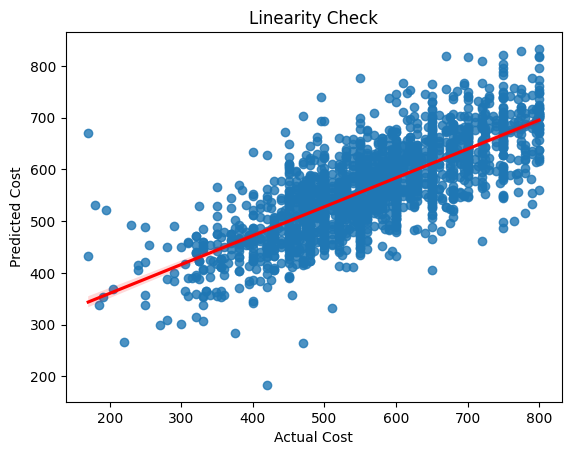

In [21]:
# Scatter plot for linearity check
# Get actual and predicted costs as Pandas DataFrames
actual_cost = test_data.select('cost').toPandas()
predictions = lr_model.transform(test_data).select('prediction').toPandas()

# Combine the actual and predicted costs into a single DataFrame
comparison_df = actual_cost.copy()
comparison_df['predicted'] = predictions['prediction']

# Scatter plot for linearity check
sns.regplot(x='cost', y='predicted', data=comparison_df, line_kws={"color": "red"})
plt.xlabel('Actual Cost')
plt.ylabel('Predicted Cost')
plt.title('Linearity Check')
plt.show()

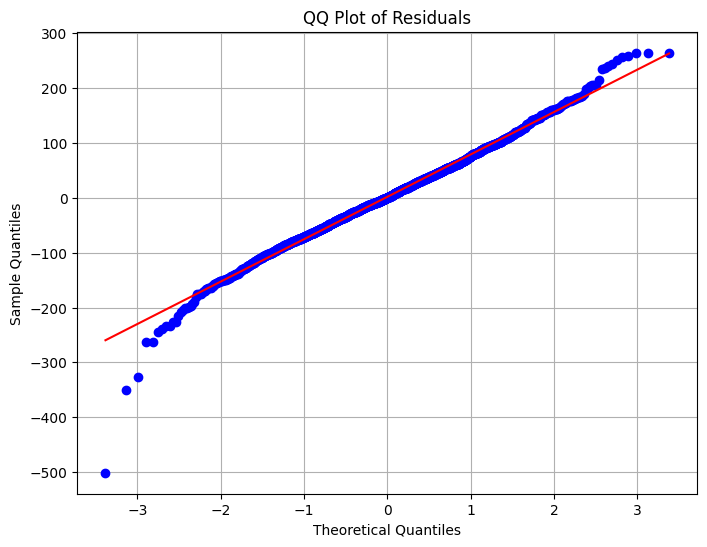

In [22]:
import scipy.stats as stats
# Step 1: Get actual and predicted costs
actual_cost = test_data.select('cost').toPandas()
predictions = lr_model.transform(test_data).select('prediction').toPandas()

# Step 2: Calculate residuals
residuals = actual_cost['cost'] - predictions['prediction']

# Step 3: Create a QQ plot
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('QQ Plot of Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')  
plt.grid()
plt.show()

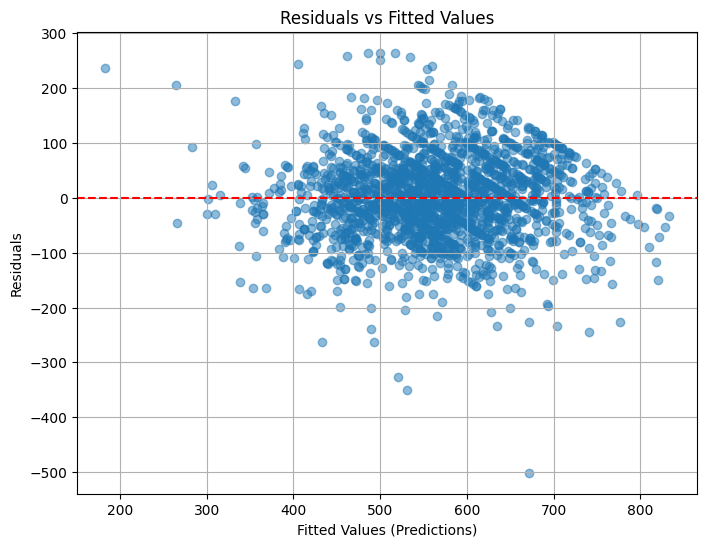

In [23]:
### Residuals vs fitted... 
predictions = lr_model.transform(test_data).select('prediction').toPandas()

# Step 2: Calculate residuals
residuals = actual_cost['cost'] - predictions['prediction']

# Step 3: Create a Residuals vs. Fitted Values Plot
plt.figure(figsize=(8, 6))
plt.scatter(predictions['prediction'], residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values (Predictions)')
plt.ylabel('Residuals')
plt.grid()
plt.show()

## TREE MODELS

In [24]:
# Create a VectorAssembler to combine feature columns into a single vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# Select the target variable (cost) and prepare the final DataFrame
data = sdf.select('cost', *feature_columns)

# Transform the features into a single vector column
data = assembler.transform(data)

# Create a MinMaxScaler instance
scaler = StandardScaler(inputCol='features', outputCol='scaled_features')

# Fit the scaler to the data
scaler_model = scaler.fit(data)

# Transform the data using the fitted scaler
data = scaler_model.transform(data)

# Split the data into training and test sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=1003)

In [25]:
# Initialize the Gradient Boosting model
gbt = GBTRegressor(featuresCol='scaled_features', labelCol='cost', maxIter=50)

# Fit the model to the training data
gbt_model = gbt.fit(train_data)

In [26]:
# Print model summary
print("Gradient Boosting Model Summary")
print("Number of Trees: ", gbt_model.getNumTrees)

# Evaluate the model on the test data
gbt_predictions = gbt_model.transform(test_data)

# Create evaluators for RMSE, MAE, and R-squared
rmse_evaluator = RegressionEvaluator(labelCol="cost", predictionCol="prediction", metricName="rmse")
mae_evaluator = RegressionEvaluator(labelCol="cost", predictionCol="prediction", metricName="mae")
r2_evaluator = RegressionEvaluator(labelCol="cost", predictionCol="prediction", metricName="r2")

# Evaluate the model on the test data
gbt_rmse = rmse_evaluator.evaluate(gbt_predictions)
gbt_mae = mae_evaluator.evaluate(gbt_predictions)
gbt_r2 = r2_evaluator.evaluate(gbt_predictions)

# Print evaluation metrics
print(f"Gradient Boosting Test RMSE: {gbt_rmse}, MAE: {gbt_mae}, R2: {gbt_r2}")

Gradient Boosting Model Summary
Number of Trees:  50


Gradient Boosting Test RMSE: 63.179539929928374, MAE: 47.36782970642515, R2: 0.7121420184089027


In [27]:
# Get feature importances
gbt_feature_importances = gbt_model.featureImportances

# Create a DataFrame from the feature importances
feature_importances_df = pd.DataFrame({
    'feature': feature_columns,
    'importance': gbt_feature_importances.toArray()
})

# Sort the DataFrame by the 'importance' column in decreasing order
feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)
feature_importances_df

,feature,importance
1,beds,0.181523
0,postal_code,0.088619
2,baths,0.063301
155,pop_percentage_increase,0.047474
52,cbd_average_travel_distance_kms,0.047211
...,...,...
138,mar_2020,0.000000
124,sep_2016,0.000000
136,sep_2019,0.000000
126,mar_2017,0.000000
